In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import re
from datetime import datetime

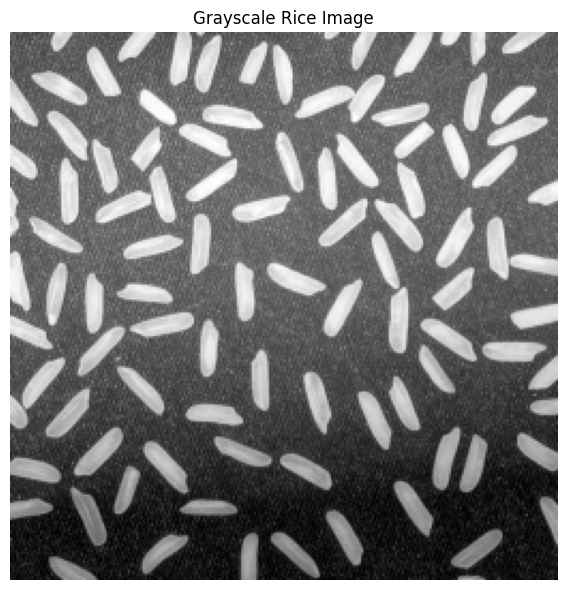

In [3]:
img = cv.imread('figs/rice.png')
gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title("Grayscale Rice Image")
plt.tight_layout()
plt.show()

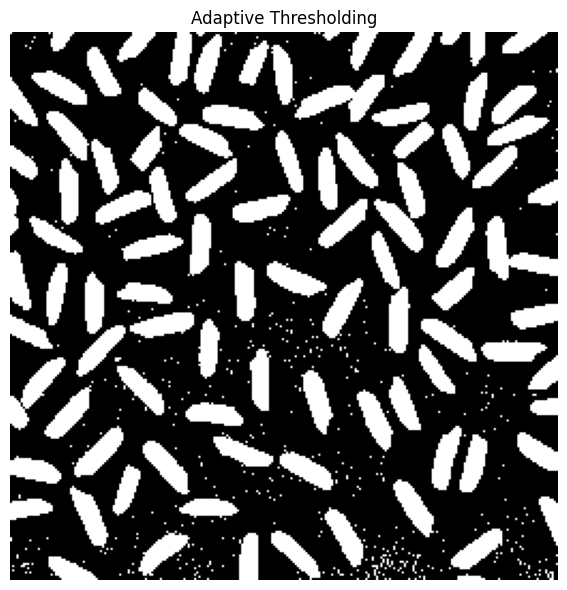

In [4]:
adaptive_thresh = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv.THRESH_BINARY, 101, 1)
plt.figure(figsize=(6,6))
plt.imshow(adaptive_thresh, cmap='gray')
plt.axis('off')
plt.title("Adaptive Thresholding")
plt.tight_layout()
plt.savefig('figs/rice_binary.png')
plt.show()

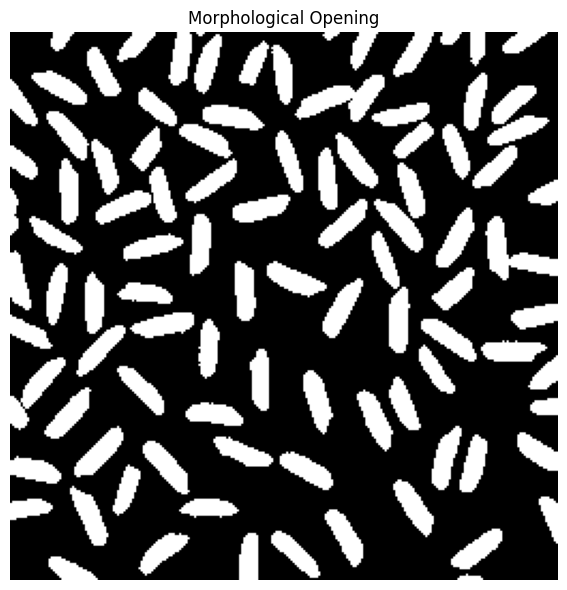

In [5]:
# noise removal
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
opening = cv.morphologyEx(adaptive_thresh,cv.MORPH_OPEN,kernel, iterations = 1)

plt.figure(figsize=(6,6))
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.title("Morphological Opening")
plt.tight_layout()
plt.savefig('figs/rice_opening.png')
plt.show()

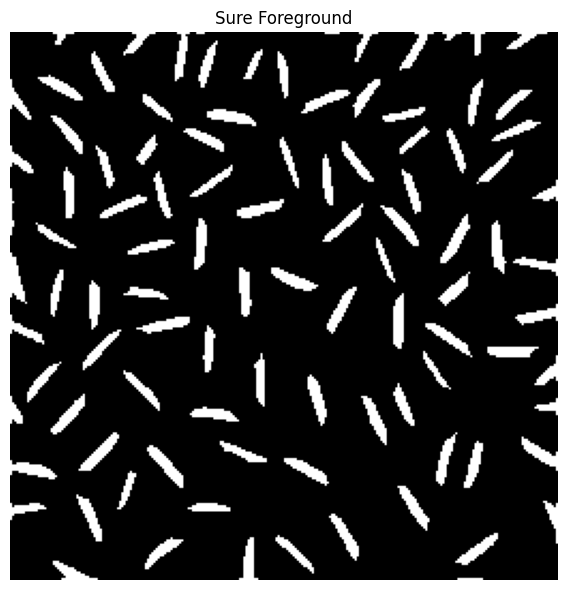

In [6]:
maintain_border_pixels = True

if maintain_border_pixels:
    h, w = opening.shape
    border = 1 # width of protected border region

    border_mask = np.zeros_like(opening, dtype=np.uint8)
    border_mask[:border, :] = 1
    border_mask[-border:, :] = 1
    border_mask[:, :border] = 1
    border_mask[:, -border:] = 1

    center_mask = 1 - border_mask
    
    ## Finding foreground area
    # The distance transform links each pixel intensity to its distance from the nearest zero pixel
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,3)
    # Thresholding enables to obtain the sure foreground area
    ret, dt_fg = cv.threshold(dist_transform, 0.40 * dist_transform.max(), 255, 0)
    dt_fg = np.uint8(dt_fg)

    border_fg = cv.bitwise_and(opening, opening, mask=border_mask)

    sure_fg = cv.bitwise_or(
        cv.bitwise_and(dt_fg, dt_fg, mask=center_mask),
        border_fg
    )

    border_fg = sure_fg & border_mask
    border_fg = cv.dilate(border_fg, kernel, iterations=1)

    # Combine back
    sure_fg = (sure_fg | border_fg).astype(np.uint8)
else:
    ## Finding foreground area
    # The distance transform links each pixel intensity to its distance from the nearest zero pixel
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,3)
    # Thresholding enables to obtain the sure foreground area
    ret, sure_fg = cv.threshold(dist_transform, 0.40 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

# Marker labelling
plt.figure(figsize=(6,6))
plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.title("Sure Foreground")
plt.tight_layout()
plt.savefig('figs/rice_sure_fg.png')
plt.show()


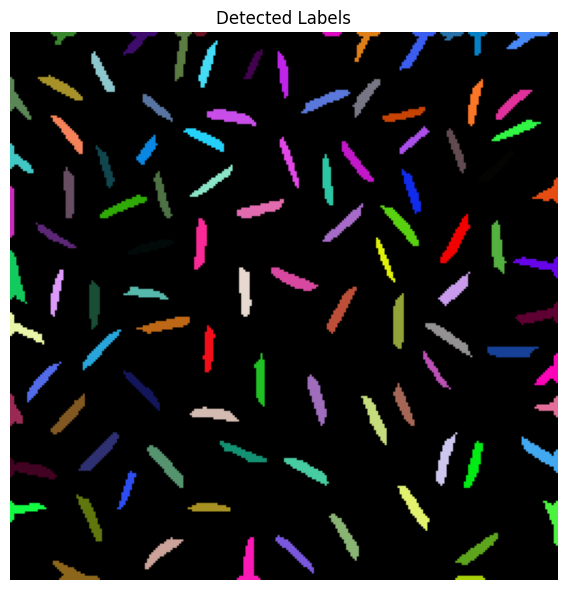

101 labels found


In [7]:
# Counts the number of individualy connected components and associates a unique label to each component
num_labels, markers = cv.connectedComponents(sure_fg)

random_colors = np.random.rand(num_labels, 3)
random_colors[0] = [0, 0, 0]
cmap = ListedColormap(random_colors)

plt.figure(figsize=(6,6))
plt.imshow(markers, cmap=cmap)
plt.title("Detected Labels")
plt.axis('off')
plt.tight_layout()
plt.savefig('figs/rice_labels.png')
plt.show()

print(num_labels - 1, "labels found")

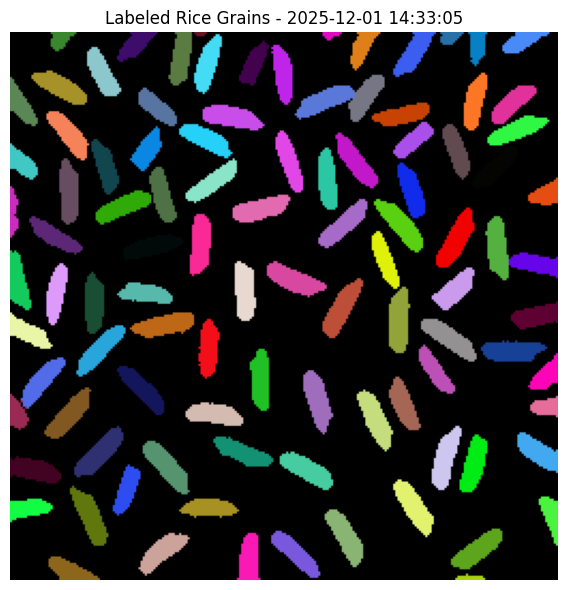

In [8]:
# Normal watershed segmentation tends to over-segment the objects espacially on the borders
#cv.watershed(img, markers)

# Morphological reconstruction to expand the markers within the opening area
reconstruct = markers.astype(np.uint16)

kernel = np.ones((3,3), np.uint8)

for _ in range(40):   
    new = cv.dilate(reconstruct, kernel)
    reconstruct = np.where(
        (reconstruct == 0) & (new > 0) & (opening > 0),
        new,
        reconstruct
    )

# timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

plt.figure(figsize=(6,6))
plt.imshow(reconstruct, cmap=cmap)
plt.title(f"Labeled Rice Grains - {timestamp}")
plt.axis('off')
plt.tight_layout()
plt.savefig('figs/rice_coloured.png')
plt.show()

In [9]:
# Update the Readme.md file
image_path = "figs/rice_coloured.png"  # path to the saved labeled rice image

# count
rice_count = num_labels - 1

# simple quality statement
if rice_count == 101:
    detection_statement = "All rice grains appear to be detected."
elif rice_count < 101:
    detection_statement = "Some rice grains are missing."
else:  # rice_count > 101
    detection_statement = "Too many rice grains detected; possible over-segmentation."

# Markdown report block
report_block = f"""
**Timestamp:** {timestamp}  
**Rice Count:** {rice_count}  
**Detection Report:** {detection_statement}  

![Labeled Rice Grains]({image_path})
""".strip()

# Update only the report section in README.md
readme_path = "README.md"

with open(readme_path, "r") as f:
    readme = f.read()

pattern = r"(<!-- RICE-REPORT-START -->)(.*?)(<!-- RICE-REPORT-END -->)"
replacement = r"\1\n" + report_block + r"\n\3"

# If the block exists → replace
if re.search(pattern, readme, flags=re.DOTALL):
    new_readme = re.sub(pattern, replacement, readme, flags=re.DOTALL)
else:
    # If missing → append at end
    new_readme = readme + "\n\n<!-- RICE-REPORT-START -->\n" + report_block + "\n<!-- RICE-REPORT-END -->\n"

with open(readme_path, "w") as f:
    f.write(new_readme)

print("Updated section in README.md with image")


Updated section in README.md with image


# Optinal Statistics

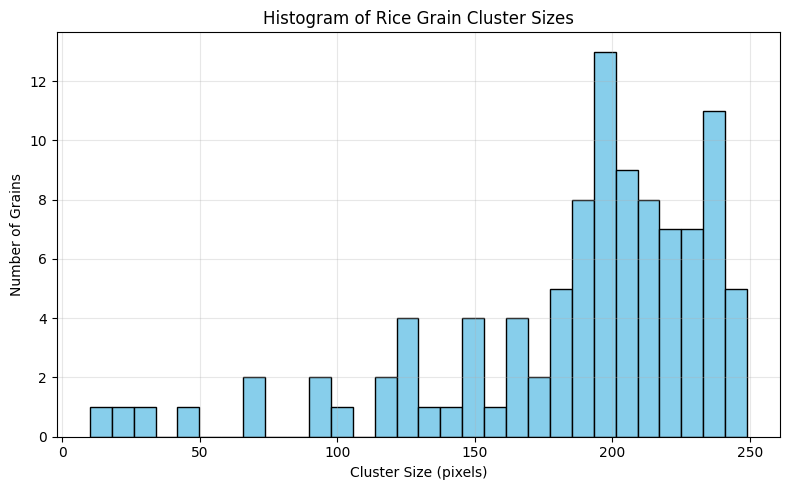

Total grains: 101
Mean cluster size: 186.93 px
Median cluster size: 201.00 px
Max cluster size: 249 px


In [10]:
# Compute pixel area of each labeled component
labels = reconstruct  # from previous cell

areas = []
for label in range(1, num_labels):  # skip background
    area = np.sum(labels == label)
    areas.append(area)

areas = np.array(areas)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(areas, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Rice Grain Cluster Sizes")
plt.xlabel("Cluster Size (pixels)")
plt.ylabel("Number of Grains")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figs/rice_cluster_size_histogram.png')
plt.show()

# Some statistics
print(f"Total grains: {len(areas)}")
print(f"Mean cluster size: {areas.mean():.2f} px")
print(f"Median cluster size: {np.median(areas):.2f} px")
print(f"Max cluster size: {areas.max()} px")
